<a href="https://colab.research.google.com/github/xpatxj/cola-fanta-sprite-classification/blob/main/cola_fanta_sprite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#instalacja pakietu gdown
!pip install -U --no-cache-dir gdown --pre
#usuwanie i tworzenie pustego katalogu data
!rm -rf data && mkdir data
#pobieranie zip-a ze zdjęciami
!gdown 1BpccrvnDWO4XcOSQz08Xc4rGYQR7gOLq -O ai.zip
#rozpakowywanie pliku data.zip do katalogu data
!unzip -q ai.zip -d data

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1BpccrvnDWO4XcOSQz08Xc4rGYQR7gOLq
From (redirected): https://drive.google.com/uc?id=1BpccrvnDWO4XcOSQz08Xc4rGYQR7gOLq&confirm=t&uuid=6695218d-9860-4468-bf28-8c970fa158b6
To: /content/ai.zip
100% 36.2M/36.2M [00:01<00:00, 22.1MB/s]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import os
import xml.etree.ElementTree as ET

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
tree = ET.parse('/content/data/ai/annotations.xml')
root = tree.getroot()

for child in root.iter('image'):
    image_name = child.attrib['name'].replace('ai/', '')
    image_label = child[0].attrib['label']

    if not os.path.isdir(f'/content/data/ai/{image_label}'):
        os.mkdir(f'/content/data/ai/{image_label}')

    os.replace(f'/content/data/ai/{image_name}', f'/content/data/ai/{image_label}/{image_name}')


In [5]:
cola_count = len(list(glob.glob('data/**/cola/*.jpg')))
fanta_count = len(list(glob.glob('data/**/fanta/*.jpg')))
sprite_count = len(list(glob.glob('data/**/sprite/*.jpg')))
print(f'{cola_count} examples of cola, {fanta_count} examples of fanta and {sprite_count} examples of sprite to train')

27 examples of cola, 26 examples of fanta and 27 examples of sprite to train


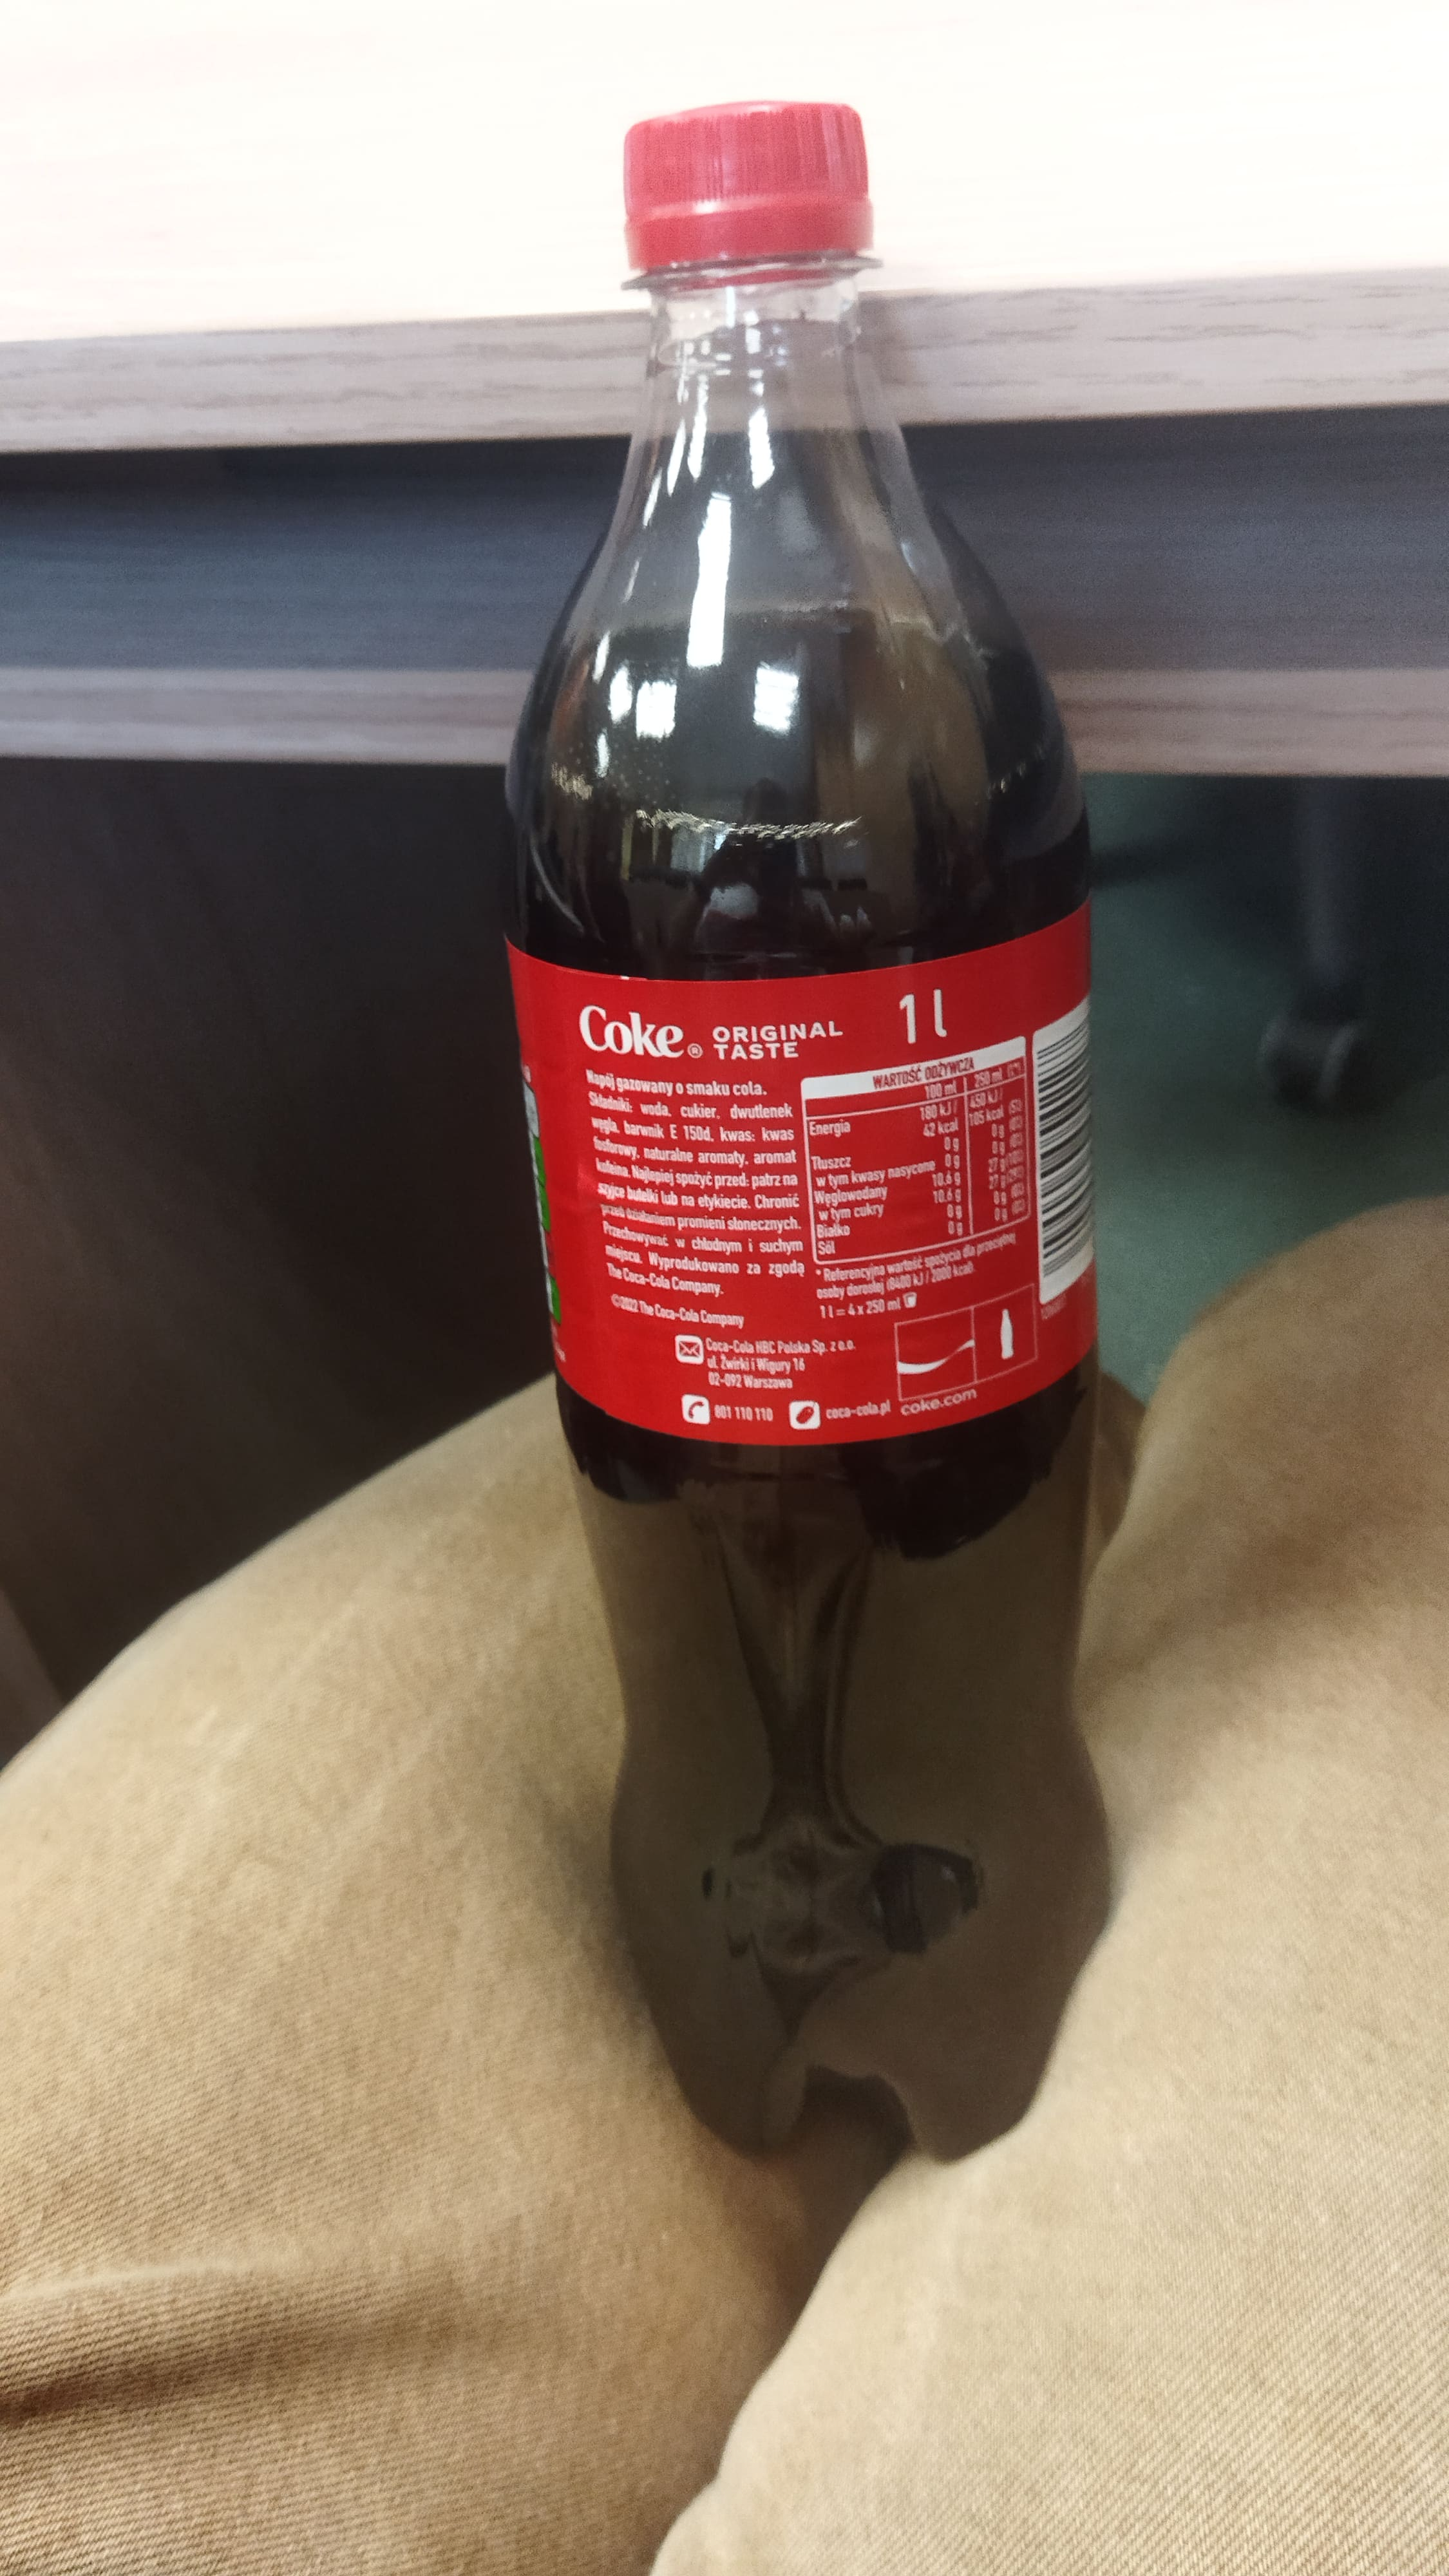

In [7]:
cola = list(glob.glob('data/ai/cola/*'))
PIL.Image.open(str(cola[3]))

In [8]:
batch_size = 32
class_count = 3

img_height = 64
img_width = 64

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'data/ai',
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'data/ai',
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 3 classes.
Using 64 files for training.
Found 80 files belonging to 3 classes.
Using 16 files for validation.


In [11]:
class_names = train_ds.class_names
print(f'class names: {class_names}')

class names: ['cola', 'fanta', 'sprite']


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(class_count)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [15]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 7s 1s/step - loss: 1.5791 - accuracy: 0.3125 - val_loss: 1.1564 - val_accuracy: 0.1875
Epoch 2/20
2/2 [==============================] - 0s 127ms/step - loss: 0.9920 - accuracy: 0.4688 - val_loss: 1.0042 - val_accuracy: 0.4375
Epoch 3/20
2/2 [==============================] - 0s 125ms/step - loss: 1.1381 - accuracy: 0.4062 - val_loss: 0.9945 - val_accuracy: 0.6875
Epoch 4/20
2/2 [==============================] - 0s 148ms/step - loss: 1.0273 - accuracy: 0.5000 - val_loss: 1.0163 - val_accuracy: 0.7500
Epoch 5/20
2/2 [==============================] - 0s 138ms/step - loss: 0.9942 - accuracy: 0.4844 - val_loss: 1.1029 - val_accuracy: 0.2500
Epoch 6/20
2/2 [==============================] - 0s 126ms/step - loss: 0.9596 - accuracy: 0.4531 - val_loss: 1.0886 - val_accuracy: 0.3125
Epoch 7/20
2/2 [==============================] - 0s 133ms/step - loss: 0.8993 - accuracy: 0.5156 - val_loss: 0.9347 - val_accuracy: 0.5625
Epoch 8/20
2/2 [=======

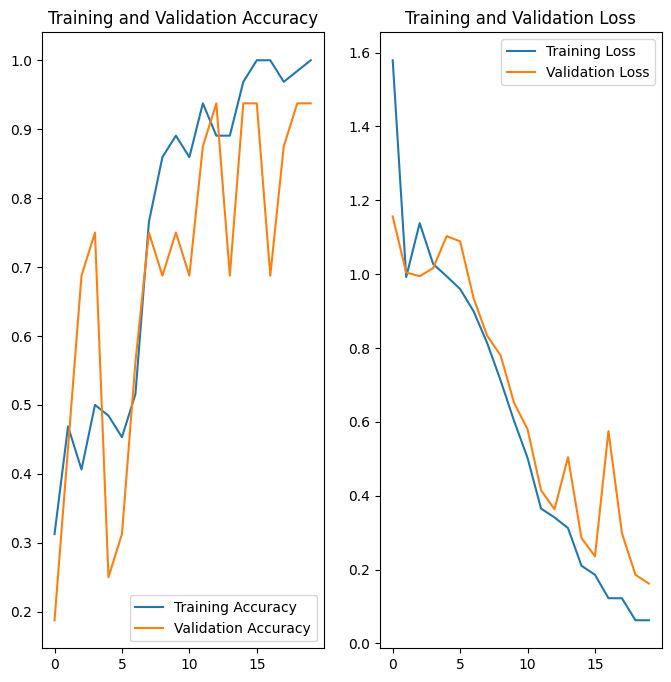

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
from sklearn.metrics import classification_report
def evaluate_model(val_ds, model):
    y_pred = []
    y_true = []

    for batch_images, batch_labels in val_ds:
        predictions = model.predict(batch_images, verbose=0)
        y_pred = y_pred + np.argmax(tf.nn.softmax(predictions), axis=1).tolist()
        y_true = y_true + batch_labels.numpy().tolist()
    print(classification_report(y_true, y_pred))

evaluate_model(val_ds, model)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         7

    accuracy                           0.94        16
   macro avg       0.92      0.94      0.92        16
weighted avg       0.95      0.94      0.94        16

